In [15]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import yfinance as yf
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Set random seed
np.random.seed(42)

# Load and clean the CSV
df = pd.read_csv("../Data/^GSPC.csv")
df = df[df["Price"] != "Ticker"]
df = df[df["Price"] != "Date"]
df[['Close','High', 'Low', 'Open', 'Volume']] = df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)
df['Price'] = pd.to_datetime(df['Price'])
df.set_index('Price', inplace=True)
df.index.name = None

# Define feature generation
def add_features(data):
    """Create additional technical indicators and prediction target while keeping alignment intact"""
    df = data.copy()

    # Technical indicators
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Close'].pct_change().rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['Return'] = df['Close'].pct_change()

    # Feature engineering
    df['X_MA5'] = (df['Close'] - df['MA5']) / df['Close']
    df['X_MA10'] = (df['Close'] - df['MA10']) / df['Close']
    df['X_MA20'] = (df['Close'] - df['MA20']) / df['Close']
    df['X_MA5_10'] = (df['MA5'] - df['MA10']) / df['Close']
    df['X_MA10_20'] = (df['MA10'] - df['MA20']) / df['Close']
    df['X_Volatility'] = df['Volatility']
    df['X_Momentum'] = df['Momentum']
    df['X_Return'] = df['Return']
    df['X_Return_5'] = df['Return'].rolling(5).sum()
    df['X_VOL_CHG'] = df['Volume'].pct_change(5)

    # Target: use binary or multi-class depending on your setup
    df['Target'] = np.where(df['Return'].shift(-1) > 0.005, 2,
                    np.where(df['Return'].shift(-1) < -0.005, 0, 1))

    return df  # ❗ Keep full index, no dropna()

# Helper functions to extract features and labels
def get_X(data):
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values

def get_y(data):
    return data.Target.values

# Apply features
df = add_features(df)


In [36]:
class XGBoostStrategy(Strategy):
    n_estimators = 100
    max_depth = 5
    learning_rate = 0.1
    train_size = 200
    price_delta = 0.01  # take-profit and stop-loss % (1%)
    
    def init(self):
        # Load data with features
        full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')

        
        # Align with backtesting data
        self.all_data = full_df

        
        # Precompute features and mapping
        self.X_all = get_X(self.all_data)
        self.y_all = get_y(self.all_data)
        self.feature_index = {i: i for i in range(len(self.all_data))}
        self.df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')
        self.features = [col for col in self.data.df.columns if col.startswith("X_")]
        
        # For visualization
        self.pred = self.I(lambda: np.zeros(len(self.data)), name='prediction')
        
        # Train XGBoost model once
        self.model = XGBClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            use_label_encoder=False,
            eval_metric='mlogloss',  # For multiclass prediction
            random_state=42
        )
        
        # Use only bars with enough data
        if len(self.X_all) >= self.train_size:
            X_train = self.X_all[:self.train_size]
            y_train = self.y_all[:self.train_size]
            self.model.fit(X_train, y_train)
            
        self.predictions = []
        self.actuals = []
    
    def next(self):
        i = len(self.data)
        if i < 200:
            return

        # Prepare training and test data
        train = self.df.iloc[i-200:i-1]
        test = self.df.iloc[[i-1]]

        X_train = train[self.features].values
        y_train = train["Target"].values
        X_test = test[self.features].values
        y_true = test["Target"].values[0]

        # Fit model and predict
        self.model.fit(X_train, y_train)
        prediction = self.model.predict(X_test)[0]
        self.pred[-1] = prediction

        # Store prediction and actual label
        if prediction in [0, 1, 2]:
            self.predictions.append(prediction)
            self.actuals.append(int(y_true))

        # Execute trade
        if prediction == 2:
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif prediction == 0:
            if not self.position.is_short:
                self.position.close()
                self.sell()

In [37]:
bt = Backtest(df, XGBoostStrategy, cash=10_000, commission=.0002)
backtest = bt.run()
backtest

/var/folders/qj/c7654q5s2zb76938lp4d13y80000gn/T/ipykernel_22923/636382163.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')
/var/folders/qj/c7654q5s2zb76938lp4d13y80000gn/T/ipykernel_22923/636382163.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:05:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest.run:   0%|          | 0/986 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:05:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:05:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:05:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:05:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Start                     2020-01-30 00:00:00
End                       2023-12-29 00:00:00
Duration                   1429 days 00:00:00
Exposure Time [%]                    77.91287
Equity Final [$]                   7742.82519
Equity Peak [$]                   10317.77188
Commissions [$]                      399.8132
Return [%]                          -22.57175
Buy & Hold Return [%]                45.25956
Return (Ann.) [%]                     -6.3228
Volatility (Ann.) [%]                10.12531
CAGR [%]                             -4.41104
Sharpe Ratio                         -0.62445
Sortino Ratio                        -0.84151
Calmar Ratio                         -0.21485
Alpha [%]                           -25.84012
Beta                                  0.07221
Max. Drawdown [%]                   -29.42865
Avg. Drawdown [%]                    -5.45584
Max. Drawdown Duration     1057 days 00:00:00
Avg. Drawdown Duration      163 days 00:00:00
# Trades                          

In [38]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):

    print("Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (0)', 'Neutral (1)', 'Up (2)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [39]:
bt.plot()

GridPlot(id='p1780', ...)

Evaluation Metrics
Accuracy: 0.3896
Precision (macro): 0.3626
F1 Score (macro): 0.3605


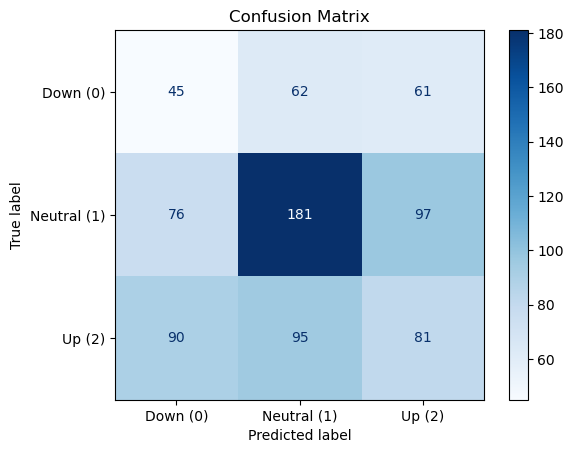

In [40]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)